In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexMTLPytorchModel import ConvexMTLPytorchRegressor
from convexmtl_torch.model.GraphLaplacianMTLPytorchModel import GraphLaplacianMTLPytorchRegressor

from convexmtl_torch.model.utils import NeuralNetwork

from sklearn.model_selection import GridSearchCV

from convexmtl_torch.data.MTLSyntheticDataset import MTLClustersBRegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from copy import copy

from utils import train_gs

import random


In [3]:
max_epochs=50
log_every_n_steps=10
problem = 'common'

In [4]:
seed = 1

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
mtlds = MTLClustersBRegression(n_samples_per_task=50)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

Init Synth


ic| tasks: [0, 1, 10, 11, 12, 20, 21]


TASK FUNCTIONS


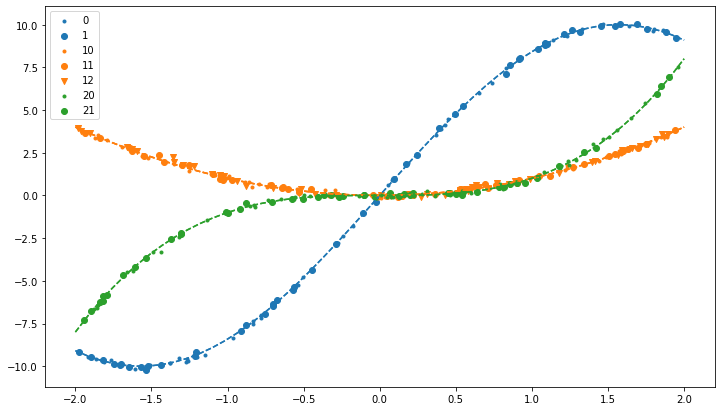

In [6]:
mtlds.plot_data_functions(X, y)

ic| rg_idx: array([0, 1])
ic| rg_idx: array([2, 3, 4])
ic| rg_idx: array([5, 6])


<AxesSubplot:>

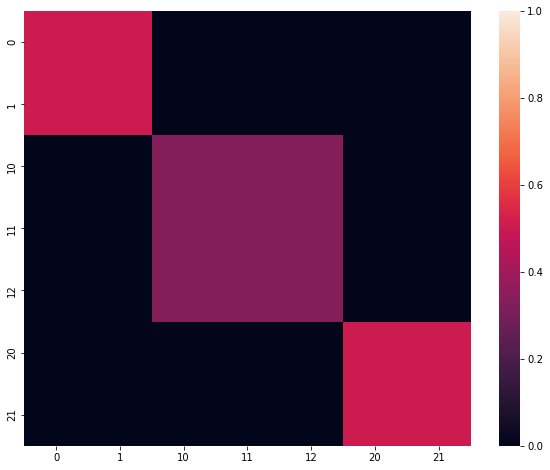

In [18]:
mtlds.plot_adj_matrix()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [20]:
X_train.shape

(1407, 2)

## ConvexMTL Torch

In [21]:
model = GraphLaplacianMTLPytorchRegressor(adj_trainable=True, train_mode='numpy', epochs=30, batch_size=32, val_size=0, early_stopping=False)
model

GraphLaplacianMTLPytorchRegressor(adj_trainable=True, batch_size=32,
                                  early_stopping=False, epochs=30, val_size=0)

In [22]:
wd_l = [10**(k) for k in range(-2, 1)]
lamblr_l = [10**(k) for k in range(-2, -1)]

params = {
    'weight_decay' : wd_l,
    # 'lambda_lr' : lamblr_l,
}
params

{'weight_decay': [0.01, 0.1, 1]}

In [23]:
# best = train_gs(model, params, X_train, y_train, model_name='convexmtlNN', problem_name=problem, scoring='neg_mean_squared_error', retrain=False)
best = model

In [24]:
best.fit(X_train, y_train)

ic| n_output: 1
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss:   0%|          | 0/30 [00:00<?, ?it/s]/home/carlos.ruizp/miniconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/core/module.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
Loss: 2.6086e+00, Tr:2.61(2.61), V:N/A: 100%|██████████| 30/30 [05:15<00:00, 10.52s/it]   


In [25]:
pred = best.predict(X_test)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(pred, y_test)

0.021566090007264324

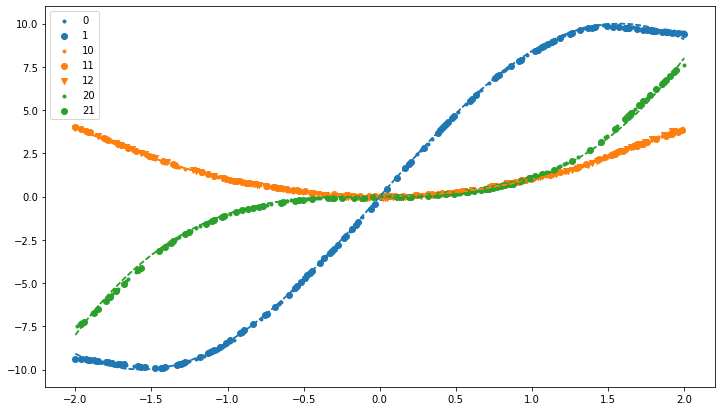

In [27]:
mtlds.plot_data_functions(X_test, pred)

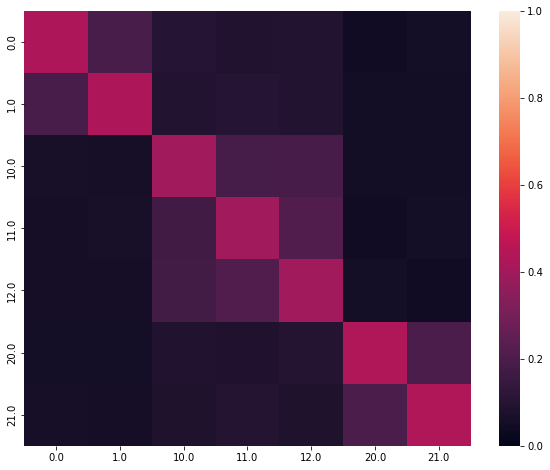

In [28]:
best.plot_adjmatrix()
plt.show()

In [29]:
nu_l = [10**k for k in range(-5, 1)]
mu_l = [10**k for k in range(-6, 0)]

X1, X2 = np.meshgrid(nu_l, mu_l)
ic(X1)
ic(X1.shape)

ic(X2.shape)

# Z = np.zeros((len(nu_l), len(mu_l)))
# for i in range(len(nu_l)):
#     for j in range(len(mu_l)):
#         mu = X1[i, j]
#         nu= X2[i, j]
#         Z[i, j] = nu + mu

ic| X1: array([[1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]])
ic| X1.shape: (6, 6)
ic| X2.shape: (6, 6)


(6, 6)

In [30]:
model = GraphLaplacianMTLPytorchRegressor(adj_trainable=True, train_mode='numpy', epochs=30, batch_size=32, val_size=0, early_stopping=False)
model

GraphLaplacianMTLPytorchRegressor(adj_trainable=True, batch_size=32,
                                  early_stopping=False, epochs=30, val_size=0)

In [31]:
from sklearn.base import clone
import joblib
import os

RESULTS_DIR = 'results'

real_matrix = mtlds.get_adj_matrix()

Z = np.zeros((len(mu_l), len(nu_l)))
for i in range(len(mu_l)):
    for j in range(len(nu_l)):
        nu = X1[i, j]
        mu= X2[i, j]
        ic(nu, mu)
        filename_matrix = '{}/matrixB_(nu={})_(mu={}).joblib'.format(RESULTS_DIR, np.log10(mu), np.log10(nu))
        if not os.path.exists(filename_matrix):
            model_ = clone(model)
            model_.set_params(mu=mu, nu=nu)
            model_.fit(X_train, y_train)
            pred_train = model_.predict(X_train)
            error_train = mean_squared_error(pred_train, y_train)
            pred_test = model_.predict(X_test)
            error_test = mean_squared_error(pred_test, y_test)

            adjmatrix = model_.get_adjmatrix()
            joblib.dump((adjmatrix, error_train, error_test), filename_matrix)
        else:
            adjmatrix, error_train, error_test = joblib.load(filename_matrix)
        
        dist = np.linalg.norm(adjmatrix - real_matrix)
        Z[i, j] = dist
        

ic| rg_idx: array([0, 1])
ic| rg_idx: array([2, 3, 4])
ic| rg_idx: array([5, 6])
ic| nu: 1e-05, mu: 1e-06
ic| n_output: 1
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss:   0%|          | 0/30 [00:00<?, ?it/s]/home/carlos.ruizp/miniconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/core/module.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
Loss: 7.5334e-01, Tr:0.75(0.75), V:N/A: 100%|██████████| 30/30 [04:50<00:00,  9.69s/it]   
ic| nu: 0.0001, mu: 1e-06
ic| n_output: 1
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss:   0%|          | 0/30 [00:00<?, ?it/s]/home/carlos.ruizp/miniconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/core/module.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely becau

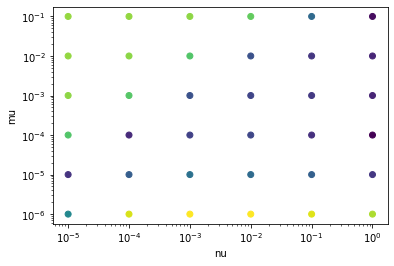

In [32]:
cm = plt.cm.get_cmap('viridis')
plt.scatter(X1, X2, c=Z, cmap=cm)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('mu')
plt.show()

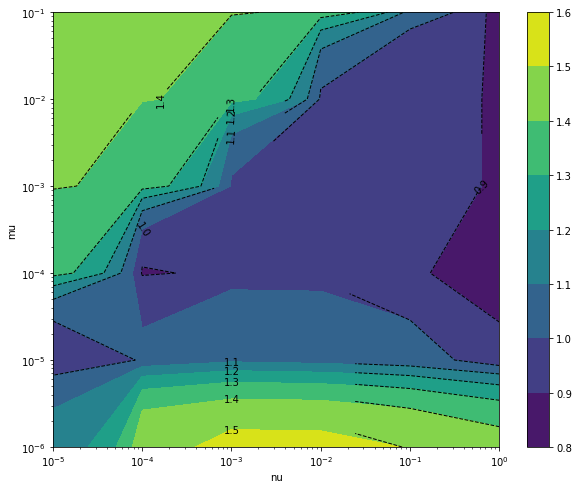

In [33]:
fig = plt.figure(figsize=(10, 8))
cp = plt.contour(X1, X2, Z, colors='black', linestyles='dashed', linewidths=1)
plt.clabel(cp, inline=1, fontsize=10)
cp = plt.contourf(X1, X2, Z, )
cbar = fig.colorbar(cp)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('mu')
plt.show()

## Tensorboard

In [34]:
%reload_ext tensorboard
%tensorboard --logdir=gl_common_logs/